In [1]:
from torchvision import datasets, transforms
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, RandomVerticalFlip, RandomResizedCrop
from torch.utils.data import DataLoader
import torchvision.models as models
import torch
from sklearn.metrics import classification_report, confusion_matrix , f1_score
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import torch.nn.functional as F
log_dir = os.path.join('runs', 'anomaly_experiment')
writer = SummaryWriter(log_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)  # Flatten inputs
        targets = targets.view(-1)  # Flatten targets

        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')  # Use logits
        pt = torch.exp(-BCE_loss)  # Convert to probability
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss  # Apply focal term

        return F_loss.mean() if self.reduction == 'mean' else F_loss.sum()


In [3]:
# Define transformations
train_transforms = transforms.Compose([
    RandomRotation(degrees=30),  
    RandomHorizontalFlip(p=0.5),  
    RandomVerticalFlip(p=0.5),  
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Validation images should not have augmentation
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset with transformations
train_dataset = datasets.ImageFolder(root="./new_data/train", transform=train_transforms)
val_dataset = datasets.ImageFolder(root="./new_data/dev", transform=val_transforms)
batch_size = 8
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(train_dataset.class_to_idx)  # Output: {'no_wormed': 0, 'wormed': 1}



{'no_worm': 0, 'wormed': 1}


In [4]:

# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Modify the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),  # Output single value
)

model = model.to(device)


/home/sepehr-sobhdoost/Projects/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sepehr-sobhdoost/Projects/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:

# Define optimizer

lr = 0.000003
early_stop_pt = 5
early_stop_tr = 0

num_epochs = 15
best_loss = float('inf')

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Use Focal Loss instead of BCE Loss
# criterion = FocalLoss(alpha=0.25, gamma=2)
pos_weight = torch.tensor([129 / 121]).to(device)  # Ratio of negative to positive samples
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss()




In [6]:

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Training Loop
    for iter_num, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Reshape labels

        optimizer.zero_grad()
        outputs = model(images)
        # print(labels.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        global_step = len(train_dataset) * epoch + iter_num * batch_size
        writer.add_scalar(f'Loss/train :_{batch_size}_{lr}', loss, global_step)


        # -------------------- Evaluation Phase --------------------
        model.eval()
        total_val_loss = 0

        with torch.no_grad():  # Disable gradients for evaluation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)  # Compute loss on validation set
                total_val_loss += loss.item()

                # Log validation loss
                writer.add_scalar(f'Loss/val :_{batch_size}_{lr}', loss, global_step)
    
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    # Early stopping

    if avg_val_loss < best_loss :
        best_loss = avg_val_loss
        early_stop_tr = 0
        torch.save(model.state_dict(), "./class_models/classify_best_model3.pth")
        print("New best Model saved !")
        
    else :
        early_stop_tr += 1
        if early_stop_tr >= early_stop_pt :
            print("Early stop has trigered !")
            break
        print(f"No imrovment for {early_stop_tr} epochs")

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


# Save trained model
torch.save(model.state_dict(), "./class_models/worm_resnet_focal3.pth")
print("Model trained and saved!")


New best Model saved !
Epoch 1 | Train Loss: 0.6963 | Val Loss: 0.6898
New best Model saved !
Epoch 2 | Train Loss: 0.5210 | Val Loss: 0.4979
New best Model saved !
Epoch 3 | Train Loss: 0.2939 | Val Loss: 0.2884
New best Model saved !
Epoch 4 | Train Loss: 0.1525 | Val Loss: 0.2241
New best Model saved !
Epoch 5 | Train Loss: 0.1075 | Val Loss: 0.1529
New best Model saved !
Epoch 6 | Train Loss: 0.0707 | Val Loss: 0.1226
New best Model saved !
Epoch 7 | Train Loss: 0.0509 | Val Loss: 0.1023
No imrovment for 1 epochs
Epoch 8 | Train Loss: 0.0824 | Val Loss: 0.1133
New best Model saved !
Epoch 9 | Train Loss: 0.0447 | Val Loss: 0.0905
New best Model saved !
Epoch 10 | Train Loss: 0.0428 | Val Loss: 0.0821
New best Model saved !
Epoch 11 | Train Loss: 0.0460 | Val Loss: 0.0747
No imrovment for 1 epochs
Epoch 12 | Train Loss: 0.0427 | Val Loss: 0.0801
No imrovment for 2 epochs
Epoch 13 | Train Loss: 0.0353 | Val Loss: 0.1752
No imrovment for 3 epochs
Epoch 14 | Train Loss: 0.0298 | Val Lo

In [60]:
def evaluate_f1(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).cpu().numpy()  # Move labels to CPU for sklearn
            outputs = model(images).squeeze(1)  # Get raw logits
            preds = torch.sigmoid(outputs).cpu().numpy()  # Convert to probabilities
            
            # Convert probabilities to binary predictions (Threshold = 0.5)
            preds = (preds > 0.55).astype(int)

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="binary")
    print(f"Test F1 Score: {f1:.4f}")
    return f1, all_labels, all_preds


In [31]:
test_dataset = datasets.ImageFolder(root="./new_data/test", transform=val_transforms)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# test_f1 = evaluate_f1(model, test_loader, device)


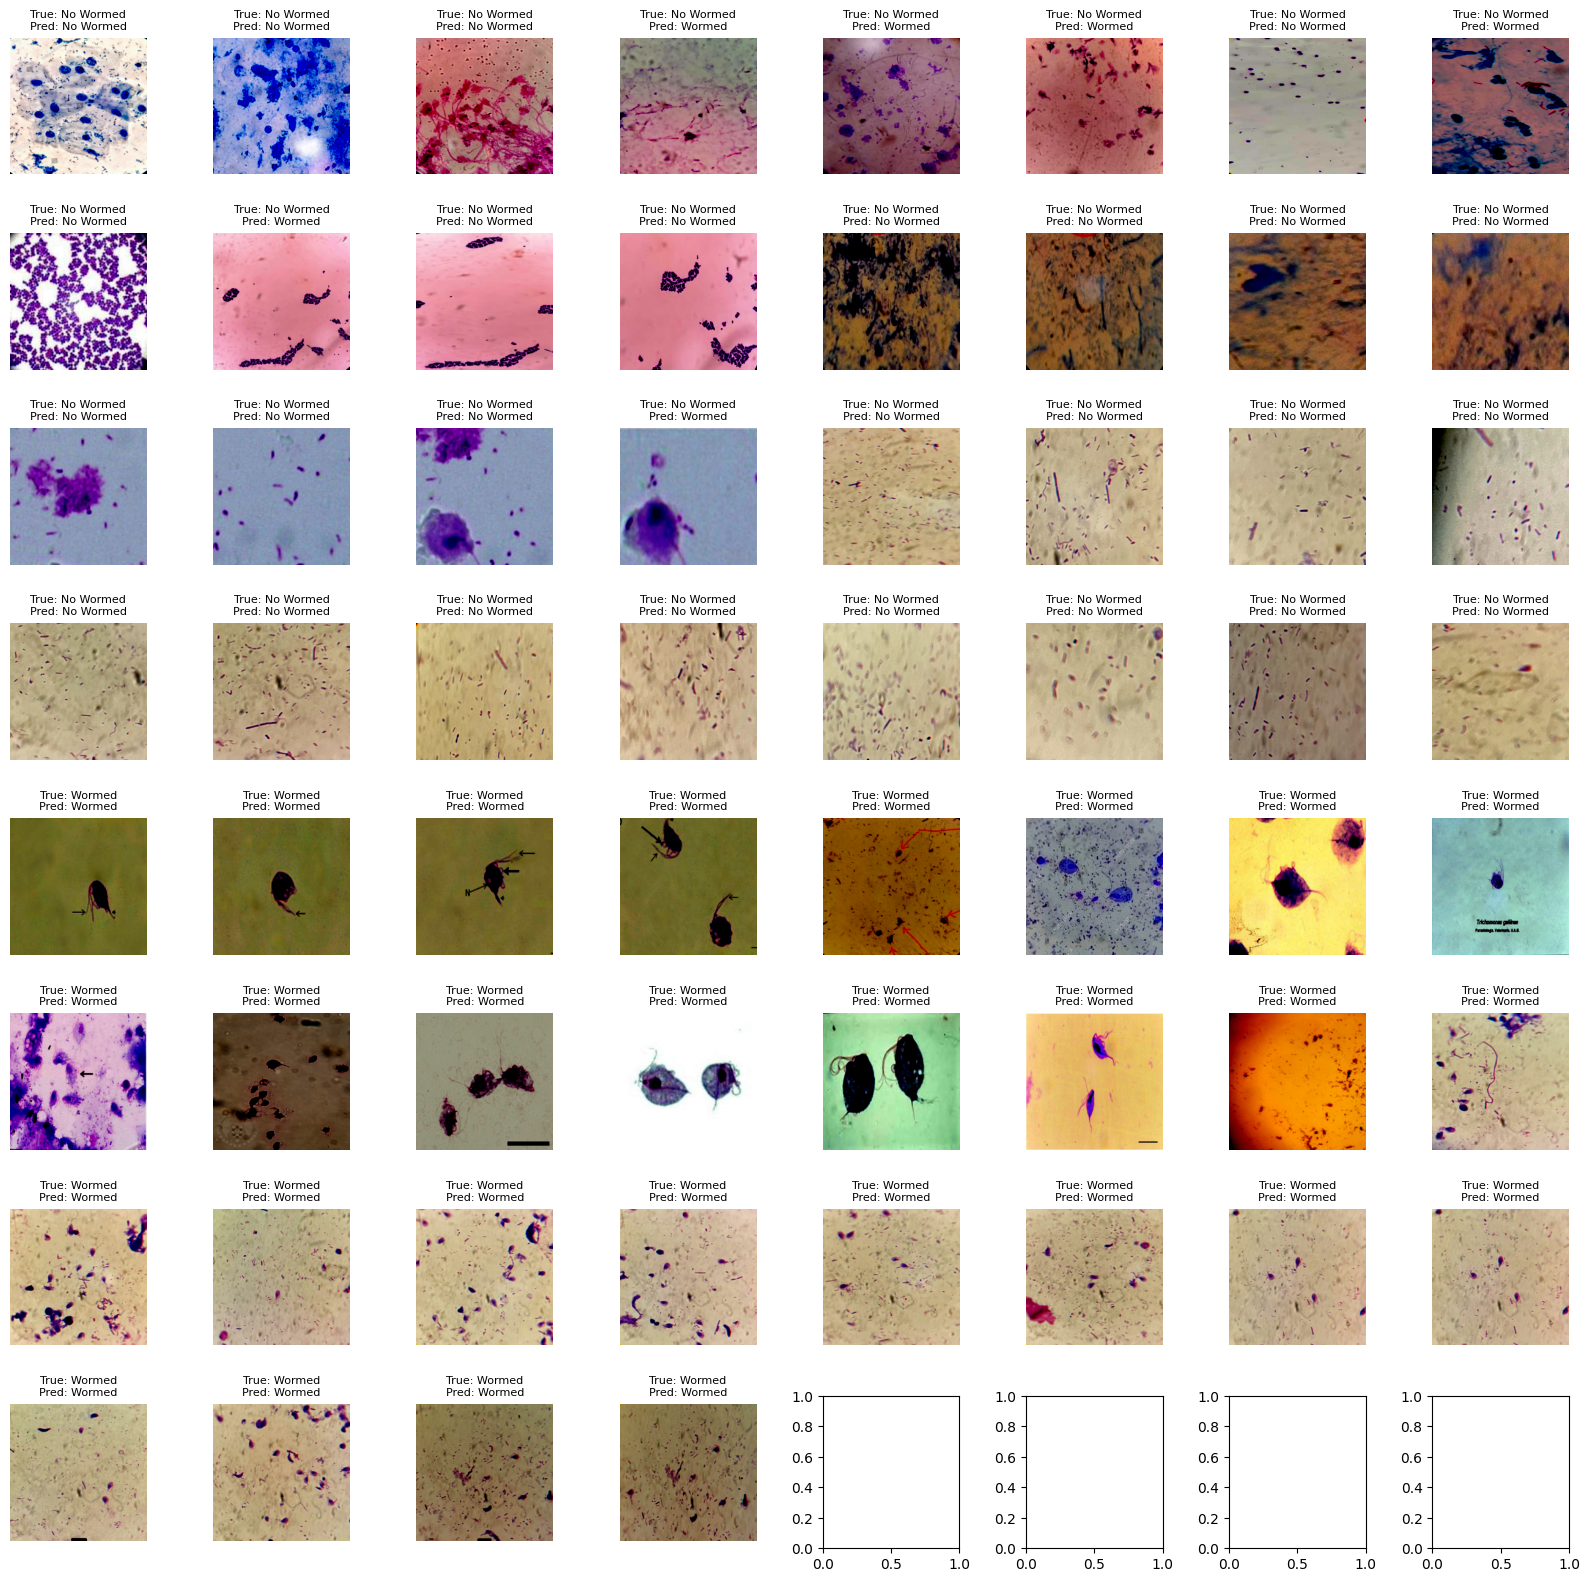

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def plot_images_with_predictions(model, test_loader, device, num_images=64):
    model.eval()  # Set model to evaluation mode
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))  # 8x8 grid
    all_preds = []
    all_labels = []
    image_count = 0  # Track number of images plotted

    for images, labels in test_loader:
        batch_size = images.shape[0]
        for j in range(batch_size):
            if image_count >= num_images:  # Stop after plotting 64 images
                break

            # Select the image and its label
            image = images[j].to(device)
            label = labels[j].item()
            all_labels.append(label)

            # Make prediction
            with torch.no_grad():
                output = model(image.unsqueeze(0).to(device))  # Add batch dimension
                prediction = torch.sigmoid(output).item()  # Apply sigmoid to get probability

            # Convert label and prediction to binary (threshold > 0.5)
            predicted_label = 1 if prediction > 0.55 else 0
            all_preds.append(predicted_label)

            # Convert image to numpy for plotting
            image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to HxWxC
            image = np.clip(image, 0, 1)  # Normalize for display

            # Plot image in the correct position
            ax = axes[image_count // 8, image_count % 8]
            ax.imshow(image)
            ax.set_title(f"True: {'Wormed' if label == 1 else 'No Wormed'}\nPred: {'Wormed' if predicted_label == 1 else 'No Wormed'}", fontsize=8)
            ax.axis('off')

            image_count += 1

        if image_count >= num_images:  # Stop if we reach 64 images
            break

    # f1 = f1_score(t_labels, preds, average="binary")
    # print(f"Test F1 Score: {f1:.4f}")
    # cmatrx= confusion_matrix(t_labels,all_preds)

    plt.tight_layout()
    plt.savefig("./result.png", dpi=300) 

    plt.show()
    # plt.savefig("./result.png")
    # plt.savefig("plot1_3.png")

    # return cmatrx

# Call the function to visualize multiple images and predictions
plot_images_with_predictions(model, test_loader, device, num_images=64)


In [9]:
model = models.resnet50(pretrained=False)  # Set False, since we'll load custom weights

# Modify the last fully connected layer (same as before)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1)  # Output single value
)

# Load trained weights
model.load_state_dict(torch.load("./class_models/classify_best_model3.pth"))
"classify_best_model3"
model.to(device)
model.eval()
print("Model loaded successfully!")
test_f1 = evaluate_f1(model, test_loader, device)
print(test_f1)

/home/sepehr-sobhdoost/Projects/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sepehr-sobhdoost/Projects/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_4815/3739644173.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_onl

Model loaded successfully!
Test F1 Score: 0.8696
0.8695652173913043


In [14]:
test = datasets.ImageFolder(root="./finialtest", transform=val_transforms)

loader = DataLoader(test, batch_size=1, shuffle=False)
print(len(loader))
f1 = evaluate_f1(model, loader, device)
f1

26
Test F1 Score: 0.8421


0.8421052631578947

/tmp/ipykernel_4815/2243833257.py:36: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


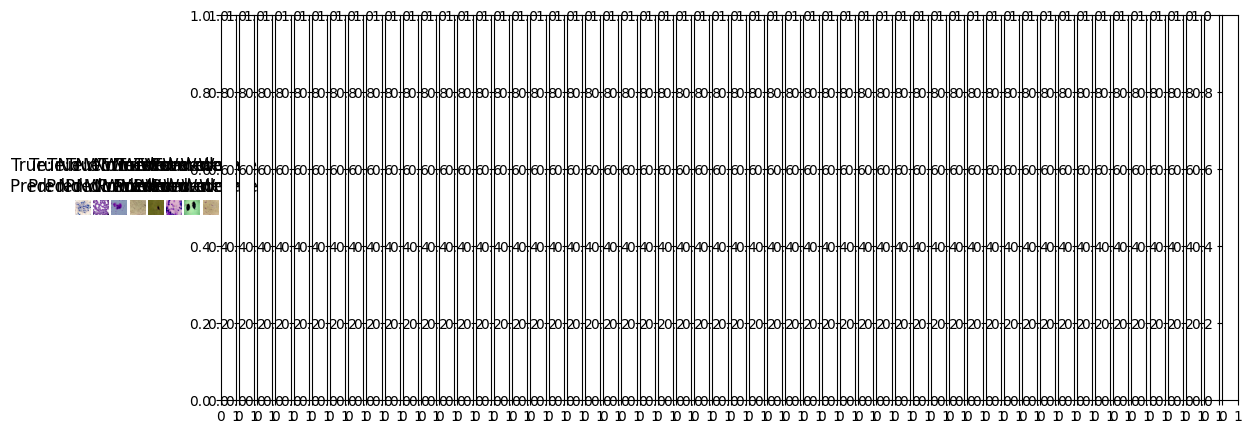

In [23]:
plot_images_with_predictions(model, test_loader, device, num_images=64)


In [62]:
test_f1, true_lables, preds = evaluate_f1(model, test_loader, device)
print(test_f1)
cmatrx= confusion_matrix(true_lables,preds)
print(cmatrx)

Test F1 Score: 0.9032
0.9032258064516129
[[26  6]
 [ 0 28]]


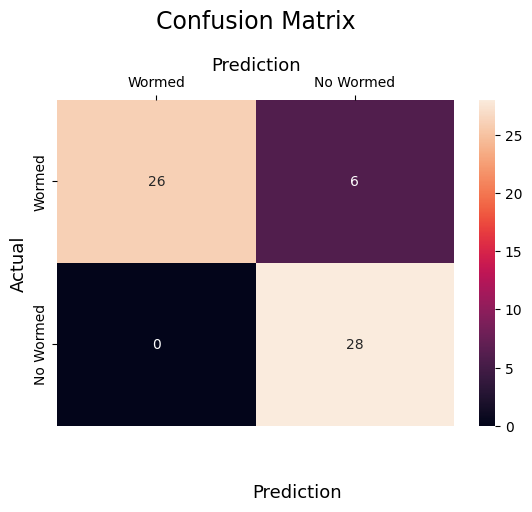

In [64]:
import seaborn as sns

sns.heatmap(cmatrx, 
            annot=True,
            fmt='g', 
            xticklabels=['Wormed','No Wormed'],
            yticklabels=['Wormed','No Wormed'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()


In [58]:
import torch
import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold(model, val_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs).cpu().numpy()

            all_probs.extend(probs)
            all_labels.extend(labels)

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Search for the best threshold
    best_threshold = 0.6
    best_f1 = 0
    thresholds = np.linspace(0.1, 0.9, 100)  # Test 20 thresholds between 0.1 and 0.9

    for threshold in thresholds:
        preds = (all_probs > threshold).astype(int)
        f1 = f1_score(all_labels, preds, average="binary")
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")
    return best_threshold, best_f1


In [59]:
x, _ = find_best_threshold(model, val_loader, device)
x

Best Threshold: 0.55, Best F1 Score: 0.9032


np.float64(0.5525252525252525)